In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gffutils
from collections import Counter
from itertools import chain
#from Bio import SeqIO
#import plotly.graph_objects as pygo

genome_dir = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/external_data/genomes/spom')



In [113]:
def sort_features_by_coord(feature_list, strand):
    #When strand is +, sorts ascending using the start coordinates
    #When strand is -, sorts descending using the end coordinates 
    max_char = '50'  #limits max characters for the feature id to be 50
    
    feature_coords = []

    for feature in feature_list: 
        feature_coords.append((feature.start, feature.end, feature.id))

    feature_coords_arr= np.array(feature_coords, dtype = [('start',int),('end', int), ('id', 'U'+max_char)])

    if strand == '+': 
        feature_sorted = np.sort(feature_coords_arr, order = 'start')
    elif strand == '-':
        feature_sorted = np.sort(feature_coords_arr, order = 'end')
        feature_sorted = np.flip(feature_sorted, 0)
    
    return feature_sorted
    

In [118]:
def get_intergenic_dists(db, chrm, strand, chrm_len_dict):

    gene_coords = {}

    strand_sign = {'-':-1, '+':1}
    
    chrm_strand_query = db.execute("SELECT id FROM features WHERE seqid='"+ chrm + "' AND strand='" + strand +"' AND featuretype='gene'").fetchall()
    
    if len(chrm_strand_query)>0:
        for gene in chrm_strand_query:
            gene_id = gene['id']
 
            #extract all CDS and 3pUTR
            #extract id and start of first CDS
            #extract id and end of last CDS

            cds_list = list(db.children(gene_id, featuretype = 'CDS'))

            cds_sorted = sort_features_by_coord(cds_list, strand)

            if strand== '+':
                first_cds_start = cds_sorted[0]['start']
                first_cds_id = cds_sorted[0]['id'] 
                last_cds_end = cds_sorted[-1]['end'] 
                last_cds_id = cds_sorted[-1]['id'] 
            elif strand == '-':
                first_cds_start = cds_sorted[0]['end']
                first_cds_id = cds_sorted[0]['id'] 
                last_cds_end = cds_sorted[-1]['start'] 
                last_cds_id = cds_sorted[-1]['id'] 
            N_cds = len(cds_sorted) 
            cds_id_list = list(cds_sorted['id'])



            #extract 3pUTR start, end, len
            three_prime_UTRs = list(db.children(gene_id, featuretype = 'three_prime_UTR'))
            N_three_prime_UTRs = len(three_prime_UTRs)
            #assert N_three_prime_UTRs<3,  'more than 2 three_prime_UTR for ' + gene_id

            if N_three_prime_UTRs==1:
                three_prime_UTR = three_prime_UTRs[0]
                three_prime_UTR_id = three_prime_UTR.id
                if strand== '+':
                    three_prime_UTR_start = three_prime_UTR.start
                    three_prime_UTR_end = three_prime_UTR.end
                    three_prime_UTR_len = three_prime_UTR_end-three_prime_UTR_start
                elif strand== '-':
                    three_prime_UTR_start = three_prime_UTR.end
                    three_prime_UTR_end = three_prime_UTR.start
                    three_prime_UTR_len = -(three_prime_UTR_end-three_prime_UTR_start)
            elif N_three_prime_UTRs==0:
                three_prime_UTR_id = None
                three_prime_UTR_len = 0
                three_prime_UTR_start = last_cds_end+strand_sign[strand]
                three_prime_UTR_end = last_cds_end+strand_sign[strand]
            elif N_three_prime_UTRs>1:
                three_prime_UTRs_sorted = sort_features_by_coord(three_prime_UTRs, strand)
                # if three_prime_UTRs_sorted['start'][-1]-three_prime_UTRs_sorted['end'][0]>1:
                # print('two three_prime_UTRs are not adjacent for gene ' + gene_id)

                three_prime_UTR_id = ':'.join(three_prime_UTRs[0].id.split(':')[0:2]) + ':' \
                                      + '_'.join([utr_id.split(':')[2] for utr_id in three_prime_UTRs_sorted['id']])

                if strand=='+':
                    three_prime_UTR_start = three_prime_UTRs_sorted['start'][0]
                    three_prime_UTR_end = three_prime_UTRs_sorted['end'][-1]
                    three_prime_UTR_len = three_prime_UTR_end-three_prime_UTR_start
                elif strand == '-':
                    three_prime_UTR_start = three_prime_UTRs_sorted['end'][0]
                    three_prime_UTR_end = three_prime_UTRs_sorted['start'][-1]
                    three_prime_UTR_len = -(three_prime_UTR_end-three_prime_UTR_start)

            
            if last_cds_end + strand_sign[strand] != three_prime_UTR_start: 
                print('{}: Warning: three prime UTR not adjacent to last CDS'.format(gene_id))
            
            # (first_CDS_start, first_CDS_id, last_CDS_end, last_CDS_id,  N_CDS, CDS_id_list, 
            #  three_prime_UTR_start, three_prime_UTR_end, three_prime_UTR_id, three_prime_UTR_len)

            gene_coords[gene_id] = (first_cds_start,
                                    first_cds_id,  
                                    last_cds_end, 
                                    last_cds_id, 
                                    N_cds, 
                                    cds_id_list, 
                                    three_prime_UTR_start, 
                                    three_prime_UTR_end, 
                                    three_prime_UTR_id, 
                                    three_prime_UTR_len
                                    )




        #find distance to the beginning of the CDS for the next gene and coord on the same strand. 

        gene_coords_df = pd.DataFrame.from_dict(gene_coords, orient='index', 
                              columns =  ('first_CDS_start', 'first_CDS_id', 'last_CDS_end', 'last_CDS_id',  'N_CDS', 'CDS_id_list', 
                                          'three_prime_UTR_start', 'three_prime_UTR_end', 'three_prime_UTR_id', 'three_prime_UTR_len')
                              )

        if strand == '+':
            gene_coords_sorted = gene_coords_df.sort_values(by='first_CDS_start', ascending=True)
            gene_coords_sorted['first_CDS_start_next_gene'] = list(gene_coords_sorted['first_CDS_start'])[1:] + [chrm_len_dict[chrm]]
            gene_coords_sorted['next_gene_id'] = list(gene_coords_sorted.index)[1:] + ['chromosome_end']
            gene_coords_sorted['intergenic_distance'] = gene_coords_sorted['first_CDS_start_next_gene']-gene_coords_sorted['last_CDS_end']

            #for genes with genes that start inside, finds the next gene downstream of their start

            for edge_case_id, row in gene_coords_sorted[gene_coords_sorted['intergenic_distance']<0].iterrows():

                next_gene_row = gene_coords_sorted.loc[(gene_coords_sorted['first_CDS_start']> row['last_CDS_end'])].iloc[0,:]
                gene_coords_sorted.loc[edge_case_id,
                                       ['next_gene_id', 'first_CDS_start_next_gene', 'intergenic_distance']
                                      ] = [
                                           next_gene_row.name,
                                           next_gene_row['first_CDS_start'], 
                                           next_gene_row['first_CDS_start']-row['last_CDS_end']
                                         ]

        elif strand == '-': 
            gene_coords_sorted = gene_coords_df.sort_values(by='first_CDS_start', ascending=False)
            gene_coords_sorted['first_CDS_start_next_gene'] = list(gene_coords_sorted['first_CDS_start'])[1:] + [0]
            gene_coords_sorted['next_gene_id'] = list(gene_coords_sorted.index)[1:] + ['chromosome_begin']
            gene_coords_sorted['intergenic_distance'] = -(gene_coords_sorted['first_CDS_start_next_gene']-gene_coords_sorted['last_CDS_end'])

            #for genes with genes that start inside, finds the next gene downstream of their start

            for edge_case_id, row in gene_coords_sorted[gene_coords_sorted['intergenic_distance']<0].iterrows():

                next_gene_row = gene_coords_sorted.loc[(gene_coords_sorted['first_CDS_start'] < row['last_CDS_end'])].iloc[0,:]
                gene_coords_sorted.loc[edge_case_id,
                                       ['next_gene_id', 'first_CDS_start_next_gene', 'intergenic_distance']
                                      ] = [
                                           next_gene_row.name,
                                           next_gene_row['first_CDS_start'], 
                                           -(next_gene_row['first_CDS_start']-row['last_CDS_end'])
                                         ]


        return gene_coords_sorted
    
    else:
        print('No genes detected on Chromosome: {} , Strand:{} '.format(chrm, strand))
        return None

## Build gtf file for use in cellranger with s.pombe
3'UTRs based on Mata 2013 Supp7

Identifies intergenic regions and defines 3prime UTR lengths according to the rule: 
3prime UTR annotation: min(max(annotated 3'UTR from 2020 pombase,3PC data), intergenic region between genes on the same strand )

In [107]:
#Import UTR lengths
utrs = pd.read_excel(genome_dir + os.sep +  'rna-10-1407-s03.xls', index_col=0, skiprows = 1,  sheet_name='Dataset S7')

#Some genes that had more than one annotated UTR had multiple enries in that dataset.  Usually four entries with two different lenghts. I am taking the max. 

quadruplicate_list = [gene_id for gene_id, count in Counter(utrs.index).items() if count>1]

for gene_id in quadruplicate_list:

    common_name_list = []
    L_pombase_list = []
    L_cluster_list = []
    L_3PC_list = []


    for gene_id, (common_name, L_pombase, L_cluster, L_3PC) in utrs.loc[gene_id,:].iterrows():
        common_name_list.append(common_name)
        L_pombase_list.append(L_pombase)
        L_cluster_list.append(L_cluster)
        L_3PC_list.append(L_3PC)

    assert len(set(common_name_list))==1, '{}: multiple common names'.format(gene_id)
    assert len(set(L_cluster_list))==1, '{}: multiple clusters'.format(gene_id)
    assert len(set(L_3PC_list))==1, '{}: multiple 3PC lengths'.format(gene_id)

    new_row = (common_name_list[0], max(L_pombase_list), L_cluster_list[0], L_3PC_list[0])

    utrs.drop(gene_id, inplace=True)

    utrs = utrs.append(pd.DataFrame.from_dict({gene_id: new_row}, columns = utrs.columns, orient='index'))



#('rna-10-1407-s03.xls', index_col=0, header)
#compare 3 different lengths

#add appropriate UTR to gff

#ensure gff uses just cds and 3'UTR. 

In [82]:
utrs

,Common name,Length annotated UTRs (GeneDB),Length of Longest UTR defined by cluster peaks,Longest UTR determined by 3PC
SPAC1002.02,mug31,236,248,286
SPAC1002.03c,gls2,297,164,401
SPAC1002.04c,taf11,149,288,303
SPAC1002.05c,jmj2,102,63,84
SPAC1002.07c,ats1,246,197,242
...,...,...,...,...
SPCC1620.12c,NaN,2896,2989,571
SPCC1682.05c,srp68,876,548,979
SPCC663.04,rpl39,153,194,224
SPCC830.09c,NaN,1217,1354,1400


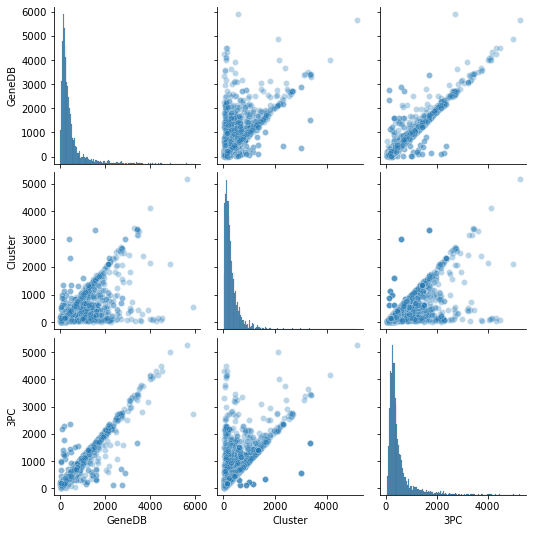

In [41]:
utrs_tidy = utrs.iloc[:,1:]

coldict = {'Length annotated UTRs (GeneDB)': 'GeneDB', 
           'Length of Longest UTR defined by cluster peaks':'Cluster' ,
           'Longest UTR determined by 3PC': '3PC'}

utrs_tidy.rename(columns = coldict, inplace=True)

sns.pairplot(utrs_tidy, plot_kws={'alpha':0.3})

In [37]:
pombase_gff_db.conn.close()

In [38]:
#  Starting from the original Pombe GTF to compare 3'UTRs
# Both Sam's GTF and the Ensembl gtf have duplicate features so need to get rid of those first. 

genome_base = genome_dir+ os.sep + 'Schizosaccharomyces_pombe_all_chromosomes_20201008'

#ensembl_gff_fname = genome_dir+os.sep + 'Schizosaccharomyces_pombe.ASM294v2.48.gff3'

pombase_gff_fname = genome_base + '.gff3'

pombase_gff_db_fname = genome_base + '.db'

create_db = True

if create_db: 
    pombase_gff_db = gffutils.create_db(pombase_gff_fname, pombase_gff_db_fname, force=True)
else: 
    try: 
        pombase_gff_db.conn.close()
    except NameError:
        print('pombase_gff_db not already open, opening')
    pombase_gff_db = gffutils.FeatureDB(pombase_gff_db_fname) 

# fname_out_unsorted = genome_dir + os.sep + 'saccharomyces_cerevisiae_R64-2-1_20150113_UTRs_pelechano_cellranger_4FP_unsorted.gtf'
# fname_out = genome_dir + os.sep + 'saccharomyces_cerevisiae_R64-2-1_20150113_UTRs_pelechano_cellranger_4FP.gtf' 


In [119]:
#Find intergenic regions, and calculate lengths for existing 3'UTR annotation.  

#Intergenic regions defined as region between last CDS in a gene and the first CDS of the next gene on the same strand.  
#There were a few cases (maybe 20-30 on chrII + strand) that had the next gene prior to the end of the gene.  This seemed to be more common for non-coding RNA. 
#In those cases the intergenic region was defined as the region between the last CDS and the first CDS of the next gene on the same strand which started after the end of the last CDS. 
#There were a few cases that had multiple three_prime_UTR features (usually an intron was present).  In those cases, I just merged the three_prime UTRs as one including start and stop.  ??

#chromosome length dict is from igv viewing of chromosomes
chrm_len_dict = {'chr_II_telomeric_gap':20000, 
                'I':5579133, 
                'II':4539804, 
                'III': 2452883, 
                'mating_type_region':20128, 
                'mitochondrial':19431
                }


#Build a dataframe listing intergenic regions and 3'UTR annotation

#In the gene_coords dataframe, I use start and stop to refer to the directional start, rather that the coordinates as they will go into the gtf file. 
#since I will only use the lengths rather than these coordinate info it shouldn't be a problem, but helps with troubleshooting.  

#To Do: 
#In np.sort I needed to define the max number of characters of the name
#check that the max number of characters for all names is less than max_char
#Are there any genes that don't have CDS's?  If so do any have UTRs annotated?  
#what biotypes to include?  
# - pseudogenic_transcripts (there are 31 of them)
# - planning to include noncoding rna (there are 1526)

# On chromosome II there were 14 cases in which the 3'UTR was listed as longer than the intergenic region, but the next gene was a non-coding RNA.  I still used the intergenic region as the max, but
# If the 3'UTR was real in that case, then reads might be attributed to the downstream non-coding RNA rather than the appropriate gene.  


gene_coords_dfs = []


for chrm in chrm_len_dict.keys(): 
    for strand in ['-','+']: 
        print('Chromosome: {}, Strand: {}'.format(chrm, strand))
        gene_coords_sorted = get_intergenic_dists(pombase_gff_db, chrm, strand, chrm_len_dict)
        gene_coords_dfs.append(gene_coords_sorted)

gene_coords_all = pd.concat(gene_coords_dfs)
    
    


Chromosome: chr_II_telomeric_gap, Strand: -
Chromosome: chr_II_telomeric_gap, Strand: +
Chromosome: I, Strand: -
Chromosome: I, Strand: +
Chromosome: II, Strand: -
Chromosome: II, Strand: +
Chromosome: III, Strand: -
SPCC4E9.01c: Warning: three prime UTR not adjacent to last CDS
SPCC553.05c: Warning: three prime UTR not adjacent to last CDS
Chromosome: III, Strand: +
Chromosome: mating_type_region, Strand: -
Chromosome: mating_type_region, Strand: +
Chromosome: mitochondrial, Strand: -
No genes detected on Chromosome: mitochondrial , Strand:- 
Chromosome: mitochondrial, Strand: +


In [120]:
#plot 3'utr length vs intergenic distance

fig,ax = plt.subplots(1,1)

x_name = 'three_prime_UTR_len'
y_name = 'intergenic_distance'

ax.scatter(gene_coords_all[x_name], gene_coords_all[y_name], alpha = 0.1)

ax.set_xlabel(x_name)
ax.set_ylabel(y_name)


Text(0, 0.5, 'intergenic_distance')

<Figure size 432x288 with 1 Axes>


In [277]:
#Genes in Mata data, not in pombe gtf: 
set(utrs.index)-set(gene_coords_all.index)

{'SPAC110.05',
 'SPAC1F12.03c',
 'SPAC4H3.12c',
 'SPAC823.02',
 'SPBC1685.12c',
 'SPBC8E4.02c'}

In [280]:
#genes in pombe gtf, not in Mata data: 
print("There are {} genes in the pombe gtf, but not in the Mata dataset, many of these are Noncoding RNA".format(len(set(gene_coords_all.index)-set(utrs.index))))


There are 2505 genes in the pombe gtf, but not in the Mata dataset, many of these are Noncoding RNA


In [285]:
#gene_coords_merge.columns

Index(['first_CDS_start', 'first_CDS_id', 'last_CDS_end', 'last_CDS_id',
       'N_CDS', 'CDS_id_list', 'three_prime_UTR_start', 'three_prime_UTR_end',
       'three_prime_UTR_id', 'three_prime_UTR_len',
       'first_CDS_start_next_gene', 'next_gene_id', 'intergenic_distance',
       'Common name', 'Length annotated UTRs (GeneDB)',
       'Length of Longest UTR defined by cluster peaks',
       'Longest UTR determined by 3PC'],
      dtype='object')

In [142]:
#Merge Mata data
gene_coords_merge = pd.merge(gene_coords_all, utrs, how = 'left', left_index = True, right_index=True )

gene_coords_merge['max(utr,3pc)'] = gene_coords_merge[['three_prime_UTR_len','Longest UTR determined by 3PC']].max(axis=1).astype('int')

gene_coords_merge['min(max(utr,3pc),intergenic_dist)'] = gene_coords_merge[['max(utr,3pc)', 'intergenic_distance']].min(axis=1).astype('int')

gene_coords_merge.to_csv(genome_dir + 'gene_coords_merge.csv')
gene_coords_merge



,first_CDS_start,first_CDS_id,last_CDS_end,last_CDS_id,N_CDS,CDS_id_list,three_prime_UTR_start,three_prime_UTR_end,three_prime_UTR_id,three_prime_UTR_len,first_CDS_start_next_gene,next_gene_id,intergenic_distance,Common name,Length annotated UTRs (GeneDB),Length of Longest UTR defined by cluster peaks,Longest UTR determined by 3PC,"max(utr,3pc)","min(max(utr,3pc),intergenic_dist)"
SPBC460.04c,15248,SPBC460.04c.1:exon:1,14073,SPBC460.04c.1:exon:1,1,[SPBC460.04c.1:exon:1],14072,14072,None,0,9803,SPBC460.02c,4270,NaN,NaN,NaN,NaN,0,0
SPBC460.02c,9803,SPBC460.02c.1:exon:1,8856,SPBC460.02c.1:exon:2,2,"[SPBC460.02c.1:exon:1, SPBC460.02c.1:exon:2]",8855,8855,None,0,3197,SPBC460.01c,5659,NaN,NaN,NaN,NaN,0,0
SPBC460.01c,3197,SPBC460.01c.1:exon:1,1479,SPBC460.01c.1:exon:1,1,[SPBC460.01c.1:exon:1],1478,1478,None,0,0,chromosome_begin,1479,NaN,NaN,NaN,NaN,0,0
SPBC460.03,11641,SPBC460.03.1:exon:1,13344,SPBC460.03.1:exon:1,1,[SPBC460.03.1:exon:1],13345,13345,None,0,16470,SPBC460.05,3126,NaN,NaN,NaN,NaN,0,0
SPBC460.05,16470,SPBC460.05.1:exon:1,18062,SPBC460.05.1:exon:1,1,[SPBC460.05.1:exon:1],18063,18063,None,0,20000,chromosome_end,1938,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPMIT.10,17808,SPMIT.10.1:exon:1,18032,SPMIT.10.1:exon:1,1,[SPMIT.10.1:exon:1],18033,18046,SPMIT.10.1:three_prime_UTR:1,13,18059,SPMITTRNAALA.01,27,NaN,NaN,NaN,NaN,13,13
SPMITTRNAALA.01,18059,SPMITTRNAALA.01.1:exon:1,18131,SPMITTRNAALA.01.1:exon:1,1,[SPMITTRNAALA.01.1:exon:1],18132,18132,None,0,18132,SPMITNCRNA.01,1,NaN,NaN,NaN,NaN,0,0
SPMITNCRNA.01,18132,SPMITNCRNA.01.1:exon:1,18405,SPMITNCRNA.01.1:exon:1,1,[SPMITNCRNA.01.1:exon:1],18406,18406,None,0,18406,SPMITTRNAGLU.01,1,NaN,NaN,NaN,NaN,0,0
SPMITTRNAGLU.01,18406,SPMITTRNAGLU.01.1:exon:1,18478,SPMITTRNAGLU.01.1:exon:1,1,[SPMITTRNAGLU.01.1:exon:1],18479,18479,None,0,18563,SPMIT.11,85,NaN,NaN,NaN,NaN,0,0


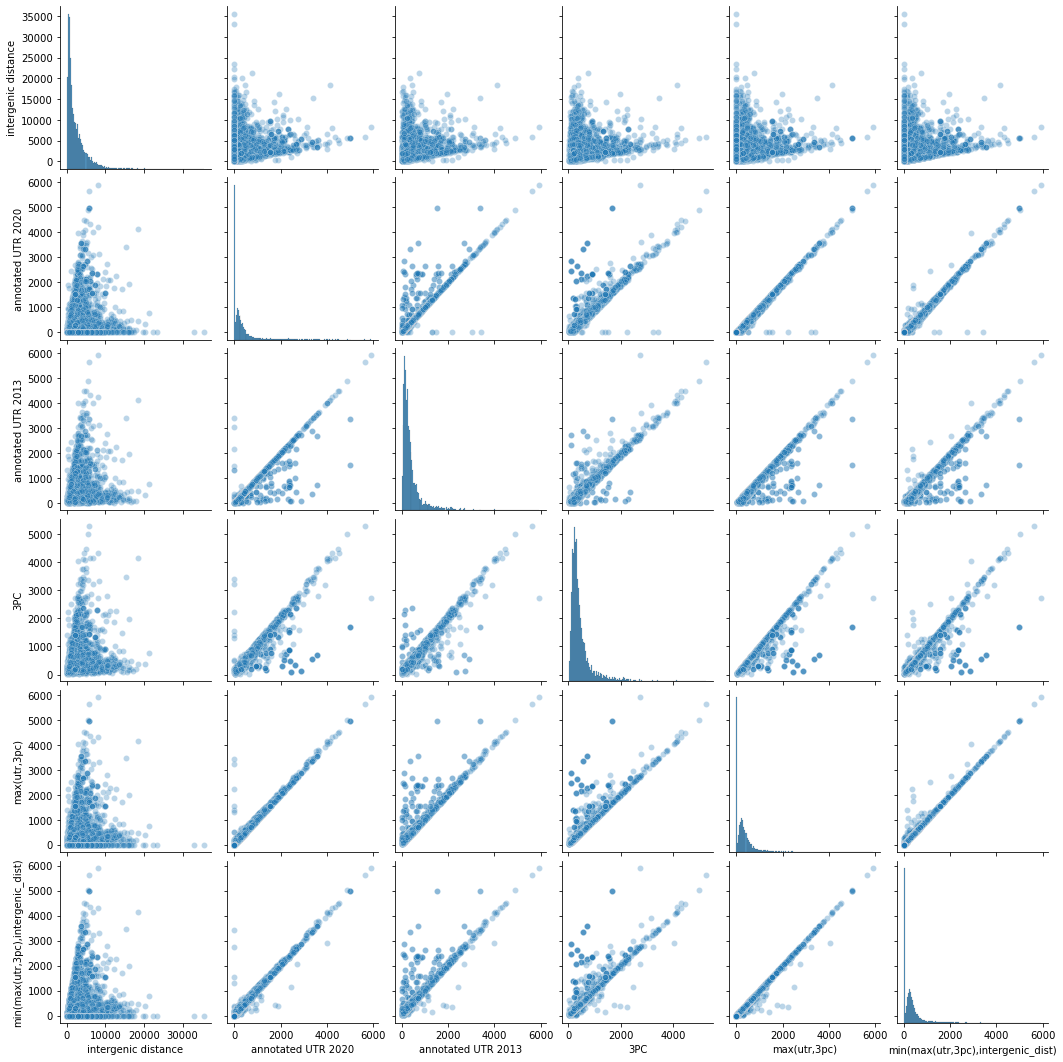

In [13]:
gene_coords_merge_tidy = gene_coords_merge.loc[:,['intergenic_distance','three_prime_UTR_len','Length annotated UTRs (GeneDB)',
                                                  #'Length of Longest UTR defined by cluster peaks',
                                                  'Longest UTR determined by 3PC',
                                                  'max(utr,3pc)', 'min(max(utr,3pc),intergenic_dist)']
                                              ]

coldict = {'intergenic_distance': 'intergenic distance', 
           'three_prime_UTR_len': 'annotated UTR 2020',
           'Length annotated UTRs (GeneDB)': 'annotated UTR 2013', 
           'Length of Longest UTR defined by cluster peaks':'Cluster' ,
           'Longest UTR determined by 3PC': '3PC', 
           'max(utr,3pc)': 'max(utr,3pc)', 
           'min(max(utr,3pc),intergenic_dist)': 'min(max(utr,3pc),intergenic_dist)'
          }

gene_coords_merge_tidy.rename(columns = coldict, inplace=True)

sns.pairplot(gene_coords_merge_tidy, plot_kws={'alpha':0.3})

In [8]:
#List of overlapping genes -> pombase

#Summary of genome features in the S. pombe GTF
for featuretype in pombase_gff_db.featuretypes():
    print('{} {}'.format(featuretype, pombase_gff_db.count_features_of_type(featuretype)))

CDS 12184
LTR_retrotransposon 14
TR_box 2
dg_repeat 11
dh_repeat 16
five_prime_UTR 4872
gap 4
gene 6998
gene_group 5
intron 5396
long_terminal_repeat 239
low_complexity_region 60
mRNA 5138
mating_type_region 1
ncRNA 1526
nuclear_mt_pseudogene 17
origin_of_replication 7
polyA_signal_sequence 1
polyA_site 17
promoter 62
pseudogenic_transcript 31
rRNA 49
region 28
regional_centromere 3
regional_centromere_central_core 4
regional_centromere_inner_repeat_region 6
repeat_region 44
snRNA 6
snoRNA 57
tRNA 196
three_prime_UTR 4801


In [31]:
gene_child_lists = []
for gc_list_full in pombase_gff_db.iter_by_parent_childs(featuretype='gene'):
    gc_list = [feature.featuretype for feature in gc_list_full]
    gc_set = set(gc_list)
    gene_child_lists.append(tuple(gc_set))

print('counter for different gene/child featuretype combinations \n')
print(Counter(gene_child_lists))

print('There are no genes present that do not have a CDS feature')

#Change to a list so that I can use chain.from_iterable
gene_child_lists = [list(gc_tuple) for gc_tuple in gene_child_lists]

gene_biotypes = list(set(chain.from_iterable(gene_child_lists))- {'CDS', 'five_prime_UTR', 'gene', 'intron', 'three_prime_UTR'})

print('Possible biotypes are {}'.format(gene_biotypes))

counter for different gene/child featuretype combinations /n
Counter({('mRNA', 'five_prime_UTR', 'CDS', 'three_prime_UTR', 'gene'): 2324, ('mRNA', 'five_prime_UTR', 'CDS', 'three_prime_UTR', 'intron', 'gene'): 2243, ('CDS', 'ncRNA', 'gene'): 1522, ('CDS', 'tRNA', 'gene'): 152, ('mRNA', 'CDS', 'gene'): 150, ('mRNA', 'CDS', 'intron', 'gene'): 124, ('mRNA', 'CDS', 'gene', 'three_prime_UTR'): 96, ('mRNA', 'CDS', 'three_prime_UTR', 'intron', 'gene'): 73, ('mRNA', 'five_prime_UTR', 'CDS', 'gene'): 64, ('mRNA', 'five_prime_UTR', 'CDS', 'intron', 'gene'): 59, ('CDS', 'snoRNA', 'gene'): 56, ('rRNA', 'CDS', 'gene'): 49, ('CDS', 'intron', 'tRNA', 'gene'): 44, ('CDS', 'pseudogenic_transcript', 'gene'): 15, ('CDS', 'intron', 'pseudogenic_transcript', 'gene'): 11, ('CDS', 'snRNA', 'gene'): 5, ('CDS', 'intron', 'ncRNA', 'gene'): 4, ('five_prime_UTR', 'CDS', 'gene', 'intron', 'pseudogenic_transcript'): 2, ('five_prime_UTR', 'CDS', 'three_prime_UTR', 'gene', 'pseudogenic_transcript'): 1, ('CDS', 'pseud

In [92]:
# # for troubleshooting
# gene_id = 'SPAC1002.05c'

# row = gene_coords_merge.loc[gene_id, :]

# #gene
# gene = pombase_gff_db[gene_id]

# strand = gene.strand

# if 'Name' in gene.attributes.keys():
#     gene_name = gene.attributes['Name'][0]
# else:
#     gene_name = gene_id

# #identify biotype
# children = pombase_gff_db.children(gene_id)
# children_list = [child for child in children]
# children_types = np.array([child.featuretype for child in children_list])

# gene_feature_set = set(gene_biotypes) & set(children_types)
# assert len(gene_feature_set)==1, '{}: more than 1 gene biotype. Biotypes Present: {}'.format(gene_id, str(gene_feature_set))
# gene_biotype_pombase = list(gene_feature_set)[0]
# gene_biotype = biotype_dict[gene_biotype_pombase]

# biotype_inds = np.where(children_types==gene_biotype_pombase)
# assert len(biotype_inds)==1, '{}: more than 1 instance of biotype {}'.format(gene_id, gene_biotype_pombase)
# transcript = children_list[biotype_inds[0][0]]
# transcript_id = transcript.id



# three_prime_len = row['min(max(utr,3pc),intergenic_dist)']
# last_cds_id = row['min(max(utr,3pc),intergenic_dist)']
# if three_prime_len >0: 
#     if strand=='+':
#         three_prime_UTR_start = row['three_prime_UTR_start']
#         three_prime_UTR_end = three_prime_UTR_start + three_prime_len
#     elif strand == '-':
#         three_prime_UTR_end = row['three_prime_UTR_start']
#         three_prime_UTR_start = three_prime_UTR_end - three_prime_len
    
#     three_prime_UTR_len_options = np.array(row[['three_prime_UTR_len','Longest UTR determined by 3PC','intergenic_distance']])
#     three_prime_UTR_options_inds = np.where(three_prime_UTR_len_options==three_prime_len)[0]
    
#     #for source use pombase first, then 3PC, then intergenic distance
#     if 0 in three_prime_UTR_options_inds: 
#         three_prime_UTR_source = 'heineike2020_PomBase'
#     elif 1 in three_prime_UTR_options_inds: 
#         three_prime_UTR_source = 'heineike2020_Mata_3PC'
#     else: 
#         assert (2 in three_prime_UTR_options_inds), '{}: source of three_prime_UTR not detected'.format(gene_id, str(row))
#         three_prime_UTR_source = 'heineike2020_intergenic'
    

# assert 'CDS' in children_types, '{}: No CDS present'
# cds_inds = np.where(children_types=='CDS')

# for cds_ind in cds_inds[0]: 
#     cds = children_list[cds_ind]
#     exon_number = cds.id.split('exon:')[1]

In [137]:
#build GTF using revised 3'UTR lengths
#could also load genegene_coords_merge from csv. 

#It appears that there are no genes with more than one transcript in the pombase gtf.  


#Notes:
#
#Only exon is used by cellranger. The gene_id and transcript_id annotation must be present, and gene_name is helpful. 
#Gene biotype is also helpful as cellranger recommends using that flag to filter feature files.  

#I will keep the Gene, Transcript, CDS, 3'UTR (modified) and exon (modified)

#gene: 
#gene lengths may need to be adjusted based on 3'UTR.  If that is the case, the source will be heineike_2020
#no transcript_id, 
#include biotype based on the biotype_dict

#transcript 
#transcript lengths may need to be adjusted based on 3'UTR.  If that is the case, the source will be heineike_2020

#It appears that there are no genes with more than one transcript in the pombase gtf.  

#possible feature types are the keys of biotype_dict, and corresponding biotypes are the values.
#biotypes from ensembl ref here https://www.ensembl.org/info/genome/genebuild/biotypes.html


biotype_dict = {'mRNA':'protien_coding',
                'snoRNA':'snoRNA',
                'rRNA':'rRNA',
                'snRNA':'snRNA',
                'ncRNA':'ncRNA',
                'tRNA':'tRNA',
                'pseudogenic_transcript':'transcribed_pseudogene'}


#transcript_id
#gene_id
#gene_name
#gene_biotype


#CDS 
#transcript_id
#gene_id 
#gene_name
#exon_number
#gene_biotype

#three_prime_UTR (modified)
#if new three_prime_UTR>0
#Using the length determined above determine new coordinates of three_prime_UTR 
#source is heineike_2020
#
#transcript_id, 
#gene_id, 
#gene_name, 
#gene_biotype, 
#three_prime_UTR_source (intergenic, mata_2013, or PomBase)

#exon (modified, only feature used in cellragner)
#source will be heineike_2020
#make exon by either copying CDS directl or, if there is a 3'UTR present, combining the 3'UTR with the last CDS.  
#transcript_id
#gene_id 
#gene_name
#gene_biotype
#exon_number (for troubleshooting, but not used in cellranger)
#exon_id:  transcript_id.exon_number or if combined with a three_prime_UTR, transcript_id.<exon_number>_three_prime_UTR (for troubleshooting, but not used in cellranger)


#First build unsorted gtf
fname_out_unsorted = genome_base + '_cellranger_unsorted.gtf'


with open(fname_out_unsorted, 'w') as fout: 
    for gene_id, row in gene_coords_merge.iterrows():
        
        #gene
        gene = pombase_gff_db[gene_id]
        
        strand = gene.strand
        
        if 'Name' in gene.attributes.keys():
            gene_name = gene.attributes['Name'][0]
        else:
            gene_name = gene_id
        
        #identify biotype
        children = pombase_gff_db.children(gene_id)
        children_list = [child for child in children]
        children_types = np.array([child.featuretype for child in children_list])

        gene_feature_set = set(biotype_dict.keys()) & set(children_types)
        assert len(gene_feature_set)==1, '{}: more than 1 gene biotype. Biotypes Present: {}'.format(gene_id, str(gene_feature_set))
        gene_biotype_pombase = list(gene_feature_set)[0]
        gene_biotype = biotype_dict[gene_biotype_pombase]
       

    
        #transcript
        biotype_inds = np.where(children_types==gene_biotype_pombase)
        assert len(biotype_inds)==1, '{}: more than 1 instance of biotype {}'.format(gene_id, gene_biotype_pombase)
        transcript = children_list[biotype_inds[0][0]]
        transcript_id = transcript.id
        
        #Set default source, start and end for genes and transcripts
        gene_transcript_source = gene.source
        assert (gene.start, gene.end)==(transcript.start,transcript.end), '{}: gene and transcript coordinates do not match.  gene=({},{}), transcript=({},{})'.format(gene_id, gene.start, gene.end, transcript.start,transcript.end) 
        gene_transcript_start = gene.start
        gene_transcript_end = gene.end        
        
        #three_prime_UTR
        three_prime_len = row['min(max(utr,3pc),intergenic_dist)']
        last_cds_id = row['last_CDS_id']
        if three_prime_len >0: 
            if strand=='+':
                three_prime_UTR_start = row['three_prime_UTR_start']
                three_prime_UTR_end = three_prime_UTR_start + three_prime_len
            elif strand == '-':
                three_prime_UTR_end = row['three_prime_UTR_start']
                three_prime_UTR_start = three_prime_UTR_end - three_prime_len  

            three_prime_UTR_len_options = np.array(row[['three_prime_UTR_len','Longest UTR determined by 3PC','intergenic_distance']])
            three_prime_UTR_options_inds = np.where(three_prime_UTR_len_options==three_prime_len)[0]

            #for source use pombase first, then 3PC, then intergenic distance
            if 0 in three_prime_UTR_options_inds: 
                three_prime_UTR_source = 'PomBase'
                orig_three_prime_UTR_inds = np.where(children_types=='three_prime_UTR')[0]
                if len(orig_three_prime_UTR_inds)>1:
                    print('{}: more than one three_prime_UTR\n three_prime_UTR coords: {} \n new three_prime_UTR coords ({},{})'.format(
                                gene_id, 
                                str([(children_list[ind].start,children_list[ind].end) for ind in orig_three_prime_UTR_inds]), 
                                three_prime_UTR_start, 
                                three_prime_UTR_end
                                )
                    )
                else: 
                    assert (children_list[orig_three_prime_UTR_inds[0]].start, children_list[orig_three_prime_UTR_inds[0]].end)==(three_prime_UTR_start, three_prime_UTR_end), '{}: new three prime UTR coords do not match old three_prime UTR coords'.format(gene_id)

            elif 1 in three_prime_UTR_options_inds: 
                three_prime_UTR_source = 'mata_2013'
                gene_transcript_source = 'heineike_2020'
                if strand=='+':
                    gene_transcript_start = gene.start
                    gene_transcript_end = three_prime_UTR_end
                elif strand == '-':
                    gene_transcript_start = three_prime_UTR_start
                    gene_transcript_end = gene.end
                
            elif 2 in three_prime_UTR_options_inds: 
                assert (2 in three_prime_UTR_options_inds), '{}: source of three_prime_UTR not detected'.format(gene_id, str(row))
                three_prime_UTR_source = 'intergenic'
                gene_transcript_source = 'heineike_2020'
                
                if strand=='+':
                    gene_transcript_start = gene.start
                    gene_transcript_end = three_prime_UTR_end
                elif strand == '-':
                    gene_transcript_start = three_prime_UTR_start
                    gene_transcript_end = gene.end
        
        #gene
        attributes = 'gene_id "{}"; gene_name "{}"; gene_biotype "{}";'.format(gene_id, gene_name, gene_biotype)

        line_items= [gene.seqid,
                     gene_transcript_source,
                     gene.featuretype,
                     str(gene_transcript_start),
                     str(gene_transcript_end),
                     gene.score, 
                     gene.strand,
                     str(gene.frame), 
                     attributes
                    ]
        
        line = '\t'.join(line_items) + '\n'
        fout.write(line)
        
        #transcript
        attributes = 'transcript_id "{}"; gene_id "{}"; gene_name "{}"; gene_biotype "{}";'.format(transcript_id, gene_id, gene_name, gene_biotype)

        line_items= [transcript.seqid,
                     gene_transcript_source,
                     'transcript',
                     str(gene_transcript_start),
                     str(gene_transcript_end),
                     transcript.score, 
                     transcript.strand,
                     str(transcript.frame), 
                     attributes
                    ]
        
        line = '\t'.join(line_items) + '\n'
        fout.write(line)       
        
        #three_prime_UTR
        if three_prime_len >0:
            attributes = 'transcript_id "{}"; gene_id "{}"; gene_name "{}"; gene_biotype "{}"; three_prime_UTR_source "{}";'.format(transcript_id, gene_id, gene_name, gene_biotype, three_prime_UTR_source)

            line_items= [transcript.seqid,
                         gene_transcript_source,
                         'three_prime_UTR',
                         str(three_prime_UTR_start),
                         str(three_prime_UTR_end),
                         transcript.score, 
                         transcript.strand,
                         str(transcript.frame), 
                         attributes
                        ]

            line = '\t'.join(line_items) + '\n'
            fout.write(line)
            
        
        #CDS and exon
        assert 'CDS' in children_types, '{}: No CDS present'
        cds_inds = np.where(children_types=='CDS')
        

        

        for cds_ind in cds_inds[0]: 
            cds = children_list[cds_ind]
            cds_id = cds.id
            
            #Default exon values:
            exon_start = cds.start
            exon_end = cds.end
            exon_number = cds_id.split('exon:')[1]
            exon_source = 'PomBase'
            exon_id = transcript_id + '.' + exon_number
            
            if (three_prime_len>0) & (cds_id == last_cds_id):   
                
                if three_prime_UTR_source != 'PomBase':
                    exon_source = 'heineike_2020'
                
                exon_id = transcript_id + '.' + exon_number + '_three_prime_UTR'
                
                if strand == '+':
                    exon_end = three_prime_UTR_end
                elif strand == '-':
                    exon_start = three_prime_UTR_start    
        
            #CDS
            attributes = 'transcript_id "{}"; gene_id "{}"; gene_name "{}"; gene_biotype "{}"; exon_number "{}";'.format(transcript_id, gene_id, gene_name, gene_biotype, exon_number)

            line_items= [cds.seqid,
                         cds.source,
                         cds.featuretype,
                         str(cds.start),
                         str(cds.end),
                         cds.score, 
                         cds.strand,
                         str(cds.frame), 
                         attributes
                        ]

            line = '\t'.join(line_items) + '\n'
            fout.write(line)
        
            #exon
            attributes = 'transcript_id "{}"; gene_id "{}"; gene_name "{}"; gene_biotype "{}"; exon_number "{}"; exon_id "{}"'.format(transcript_id, gene_id, gene_name, gene_biotype, exon_number, exon_id)

#             if gene_id == 'SPAC750.08c':
#                 assert 1==2, 'debug point'
            
            line_items= [cds.seqid,
                         exon_source,
                         'exon',
                         str(exon_start),
                         str(exon_end),
                         cds.score, 
                         cds.strand,
                         str(cds.frame), 
                         attributes
                        ]

            line = '\t'.join(line_items) + '\n'
            fout.write(line)
            

            
        
    


    



SPAC22E12.06c: more than one three_prime_UTR
 three_prime_UTR coords: [(5027779, 5028999), (5027605, 5027727)] 
 new three_prime_UTR coords (5027605,5028999)
SPAC1782.12c: more than one three_prime_UTR
 three_prime_UTR coords: [(4773736, 4774685), (4773459, 4773658)] 
 new three_prime_UTR coords (4773459,4774685)
SPAC3A11.04: more than one three_prime_UTR
 three_prime_UTR coords: [(3464297, 3465308), (3462672, 3464259)] 
 new three_prime_UTR coords (3462672,3465308)
SPAC8F11.02c: more than one three_prime_UTR
 three_prime_UTR coords: [(2855169, 2855321), (2854405, 2855090)] 
 new three_prime_UTR coords (2854405,2855321)
SPAC806.05: more than one three_prime_UTR
 three_prime_UTR coords: [(245109, 247438), (247491, 247574)] 
 new three_prime_UTR coords (245109,247574)
SPAC22F3.05c: more than one three_prime_UTR
 three_prime_UTR coords: [(698069, 701453), (701508, 703040)] 
 new three_prime_UTR coords (698069,703040)
SPAC17H9.07: more than one three_prime_UTR
 three_prime_UTR coords: [(20

In [148]:
#Print to file
with open(fname_out, 'w') as outfile:
    #outfile.write('##gff-version 3\n')
    for feature in cellranger_gtf_db.all_features(order_by = ('seqid','start')):  #,'featuretype')):
         print(feature,file=outfile)

In [145]:
#Right now it is sorted by strand - I may need to sort it. 
fname_out = genome_base + '_cellranger.gtf'
fname_out_unsorted_db = genome_base + '_cellranger_unsorted.db'



cellranger_gtf_db = gffutils.create_db(fname_out_unsorted, fname_out_unsorted_db, disable_infer_genes=True, disable_infer_transcripts = True, force=True) #, force=True)

#Print to file
with open(fname_out, 'w') as outfile:
    #outfile.write('##gff-version 3\n')
    for feature in merged_db.all_features(order_by = ('seqid','start','featuretype')):
         print(feature,file=outfile)


NameError: name 'merged_db' is not defined

In [ ]:
#     for feature in sc_pel_max_gtf_db.features_of_type('CDS_3pUTR'):
#         transcript_id = feature.attributes['ID'][0]
#         gene_id = feature.attributes['Parent'][0]
#         gene_name = SC_common_name_lookup(gene_id, SC_genename_lookup)
        
#         attributes = 'transcript_id "{}"; gene_id "{}"; gene_name "{}";'.format(transcript_id, gene_id, gene_name)
        
#         line_items= [feature.seqid,
#         feature.source,
#         'exon',
#         str(feature.start),
#         str(feature.end),
#         feature.score, 
#         feature.strand,
#         str(feature.frame), 
#         attributes]

#         line = '\t'.join(line_items) + '\n'
#         fout.write(line)
    
#     for feature in sc_pel_max_gtf_db.features_of_type('CDS'):
#         transcript_id = feature.attributes['ID'][0]
#         gene_id = feature.attributes['Parent'][0].split('_')[0]
#         gene_name = SC_common_name_lookup(gene_id, SC_genename_lookup)
        
#         attributes = 'transcript_id "{}"; gene_id "{}"; gene_name "{}";'.format(transcript_id, gene_id, gene_name)
        
#         line_items= [feature.seqid,
#         feature.source,
#         feature.featuretype,
#         str(feature.start),
#         str(feature.end),
#         feature.score, 
#         feature.strand,
#         str(feature.frame), 
#         attributes]

#         line = '\t'.join(line_items) + '\n'
#         fout.write(line)

#     for feature in sc_pel_max_gtf_db.features_of_type('gene'):
#         transcript_id = feature.attributes['ID'][0]
#         gene_id = transcript_id
#         gene_name = SC_common_name_lookup(gene_id, SC_genename_lookup)
        
#         attributes = 'transcript_id "{}"; gene_id "{}"; gene_name "{}";'.format(transcript_id, gene_id, gene_name)
        
#         line_items= [feature.seqid,
#         feature.source,
#         feature.featuretype,
#         str(feature.start),
#         str(feature.end),
#         feature.score, 
#         feature.strand,
#         str(feature.frame), 
#         attributes]

#         line = '\t'.join(line_items) + '\n'
#         fout.write(line)


In [ ]:
##Put it into a dictionary

chrm = 'V'
strand = '-'
genes_chrm_strand = unique_ids_table_genes[(unique_ids_table_genes[0]==chrm) & (unique_ids_table_genes[6]==strand)].copy()

genes_chrm_strand.sort_values(by=[3],axis=0, inplace=True)


if strand=='+':
    #if it is the plus strand, associate each gene with the start of the next gene
    #genes_chrm_strand['3prime_limit'] = list(genes_chrm_strand[3].values[1:]) + [chrm_len_dict[chrm]]
    next_starts = []
    ind_max = len(genes_chrm_strand)-1
    for ind, (gene,row) in enumerate(genes_chrm_strand.iterrows()):
        end = int(row[4])
        next_start = 'Unassigned'
        ind_try=ind
        #The next start needs to be greater than the end of the current gene
        while next_start=='Unassigned':
            ind_try = ind_try + 1
            if ind_try<ind_max:
                next_start_try = int(genes_chrm_strand.iloc[ind_try,3])
                if next_start_try>end:
                    next_start=next_start_try-1
            else:
                next_start=chrm_len_dict[chrm]
        next_starts.append(next_start)
    genes_chrm_strand['3prime_limit'] = next_starts
    
    
elif strand=='-':
    #If it is the minus strand, associate each gene with the end of the previous gene
    #genes_chrm_strand['3prime_limit'] = [0] + list(genes_chrm_strand[4].values[:-1]) 
    previous_ends = []
    for ind, (gene,row) in enumerate(genes_chrm_strand.iterrows()):
        start = int(row[3])
        previous_end = 'Unassigned'
        ind_try=ind
        #The next start needs to be greater than the end of the current gene
        while previous_end=='Unassigned':
            ind_try = ind_try - 1
            if ind_try<0:
                previous_end = 0
            else: 
                previous_end_try = int(genes_chrm_strand.iloc[ind_try,4])
                if previous_end_try<start:
                    previous_end=previous_end_try+1
        previous_ends.append(previous_end)
    genes_chrm_strand['3prime_limit'] = previous_ends

genes_chrm_strand


In [25]:
#Sam's pombe gtf does not have unique transcript IDs.  

#Questions: 

Does Sam's annotation have the same genes as the latest pombase file? 

How does 3'UTR, Mata 3'UTR, and Intergenic region compare? 

In [ ]:
#merged_db.execute("SELECT id, start FROM features WHERE seqid='"+ chrm + "' AND strand='" + strand +"' AND featuretype='gene'")

In [6]:
#Identifies line items with duplicate names and replaces those with serialized names

#Gives features with no ID but a Name feature the ID given by their name. 

#five_prime_UTR and three_prome_UTR only have Parent attribute (usually the transcript) so, give them the id of 
#five_prime_UTR:<parent_ID_serial_no>

#duplicate names are often CDS of multiple exons.  The coordinates overlap with the exons, but the CDS is not linked to the exon.  

#


# There are actually no duplicate IDs in the recent Pombase GFF.  The ensembl one also looks much less clean. 


# Also doing this code in pandas is way to slow so should do it reading one line at a time from a file.  


# #Make list of all IDs.  If no ID, stores tuple with (No_ID, <feature_type>, <Name>)
# ids = []

# pombe_gtf = pd.read_table(pombase_gff_fname, header=None, comment = '#')

# #unsorted_unique_fname = genome_base + '.unique.gff3'

# #with open(unsorted_unique_fname, w) as fout:
# for ind,row in pombe_gtf.iterrows():
#     feature_type = row[2]
#     attribs = row[8].split(';')

#     att_dict = {}
#     id_found = False
#     for att in attribs: 
#         att_type,att_val = att.split('=')
#         att_dict[att_type] = att_val
#         if att_type == 'ID':
#             ids.append(att_val)
#             id_found = True
#     if id_found==False:
#         raise ValueError("No ID!!!")
# #         if 'Name' in att_dict.keys():
# #             ids.append(('No_ID',feature_type,att_dict['Name']))
# #         elif feature_type in {'three_prime_UTR', 'five_prime_UTR'}:
# #             ids.append(('No_ID',feature_type, feature_type + ':' + att_dict['Parent'].split('transcript:')[1]))
# #         elif 'external_name' in att_dict.keys():
# #             ids.append(('No_ID',feature_type,att_dict['external_name']))
# #         else: 
# #             ids.append( 'No ID attribute. Type = ' + feature_type + '.  Other options: ' + str(att_dict))
# #             raise ValueError("No ID or Name")

#     ids_counter = Counter(ids)

#     #Makes list of tuples that represent all duplicated items in the dataset.  
#     dupe_items = []
#     for item in ids_counter.items():
#         if item[1]>1:
#             dupe_items.append(item)

        

# #Cycle through duplicated items, set Names equal to new names
# print('Cleaning duplicate Names')
# features_to_update = []
# features_to_remove = []
# for ((noid, featuretype, name),NN) in dupe_items: 
#     #Finds features in database that have matching Name attributes
#     cursor = orig_gff_db.execute("SELECT * FROM features WHERE featuretype='" + featuretype + "' AND attributes LIKE '%\"Name\":[\"" + name + "\"]%'")
#     found_features = cursor.fetchall()
#     assert len(found_features)==NN, "More features found than in duplicate items list"
    
#     #sort features with matching names by start position
#     id_start_list = []
#     for found_feature in found_features: 
#         id_start_list.append((found_feature['id'], found_feature['start']))
#     id_start_list_sorted = sorted(id_start_list, key = lambda x: x[1])
    
#     for jj, (old_id, start) in enumerate(id_start_list_sorted): 
#         found_feature = orig_gff_db[old_id]
#         features_to_remove.append(orig_gff_db[old_id])
#         new_name = found_feature['Name'][0] + '.{}'.format(jj+1) 
#         #found_feature['ID']=new_name  all features of selected types will have ID set to name next
#         found_feature['Name']=new_name
#         features_to_update.append(found_feature)
#     #orig_gff_db.conn.commit()

# orig_gff_db.delete(features_to_remove, merge_strategy='error')
# orig_gff_db.update(features_to_update, merge_strategy='error', id_spec = ['ID','Name'])
    
# print('Duplicated Names cleaned')

# #cycle through all featuretypes that had duplicate Names assigned, assign the Name field as the ID
# #Could do this for all fields that don't have an ID. 

# print('Assigning ID as name for the following featuretypes:')

# featuretypes_to_assign_ids = ['CDS', 'intron', 'noncoding_exon', 'internal_transcribed_spacer_region', 'external_transcribed_spacer_region']

# print(featuretypes_to_assign_ids)


# features_to_update = []
# features_to_remove = []
# for featuretype in featuretypes_to_assign_ids: 
#     for feature in orig_gff_db.features_of_type(featuretype):
#         features_to_remove.append(orig_gff_db[feature.id])
#         feature['ID']=feature['Name'] 
#         features_to_update.append(feature)

# orig_gff_db.delete(features_to_remove, merge_strategy='error')
# orig_gff_db.update(features_to_update, merge_strategy='error', id_spec = ['ID','Name'])

# print('IDs assigned to features')


In [10]:
# Unnecessary because I got the coords from IGV - no chromosome feature. 
# #Build dictionary of max chromosome length from Ensemble gtf
# ensembl_gtf_fname = genome_dir+os.sep + 'Schizosaccharomyces_pombe.ASM294v2.48.gff3'
# ensembl_gtf = pd.read_table(ensembl_gtf_fname, header=None, comment = '#')
# chrm_len_dict = dict(ensembl_gtf.loc[ensembl_gtf[2]=='chromosome', [0,4]])
# chrm_features = ensembl_gtf.loc[ensembl_gtf[2]=='chromosome']

# chrm_rename = {'AB325691': 'SP_chr_II_telomeric_gap', 
#                'MT': 'SP_mitochondrial', 
#                'MTR': 'SP_mating_type_region', 
#                'I':'SP_I',
#                'II': 'SP_II', 
#                'III': 'SP_III'
#               }

# chrm_len_dict = {}
# for (chrm_ensembl, chrm_len) in zip(chrm_features[0], chrm_features[4]): 
#     chrm_len_dict[chrm_rename[chrm_ensembl]] = chrm_len
    
# chrm_len_dict

In [ ]:

#old rule that I didn't use.  

#Make a list of orfs that overlap.  Transcripts that overlap both orfs will be assigned to the one with the furthest 3' end 
#(i.e. if on the + strand where end is greatest and if on the - strand where start is greatest)
#Reads that align to the CDS+3'UTR of the one with the furthest 3'end will be assigned to that gene, even if they also are assigned
#to the other overlapped orf.  The only reads that will be assigned to the overlapped ORF will be part of the CDS of that orf 
#that does not overlap.  
